**About:** This notebook contains the experiment to cluster the  
(TPHYSTND,PHQ) and find the corresponding (SOLIN,PS,LHFLX,SHFLX) on the normalized version of the dataset.

# Imports

In [1]:
from backend.imports import *
from backend.utils import *
from backend.data_generator import DataGenerator
from sklearn.cluster import MiniBatchKMeans
import joblib
from sklearn.decomposition import PCA,IncrementalPCA

# Data Transformations

In [2]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
path = '/home/ankitesh/PDE/CbrainPDE/backend/constDicts/'
path_hyam = 'hyam_hybm.pkl'
MODEL_DIR = '/oasis/scratch/comet/ankitesh/temp_project/PDEModels/'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)
scale_dict = load_pickle('/home/ankitesh/PDE/CbrainPDE/backend/constDicts/009_Wm2_scaling.pkl')

In [3]:
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

In [4]:
batch_size = 10000

In [9]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

### Load the dataset

In [5]:
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [6]:
train_data_m4k =  DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=batch_size,
    shuffle=True,
    normalize_flag=True
)

# Model

We are going to cluster on the basis of PHQ and TPHYSTND

In [7]:
n_batches = train_data_m4k.n_batches
clusters = range(1,10)
inertia = []
#Also save the models

In [ ]:
for n_clusters in clusters:
    print("n_clusters: "+str(n_clusters))
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,random_state=0,batch_size=n_batches)    
    for i in tqdm(range(train_data_m4k.n_batches)):
        Y = train_data_m4k[i][1]
        PHQ = Y[:,PHQ_idx].mean(axis=1)
        TPHYSTND = Y[:,TPHYSTND_idx].mean(axis=1)
        X = np.vstack((PHQ,TPHYSTND)).T
        kmeans = kmeans.partial_fit(X)
    inertia.append(kmeans.inertia_)
    save_pickle_model(MODEL_DIR+"PHQ_TPH_mean_K_"+str(n_clusters)+".pkl",kmeans)

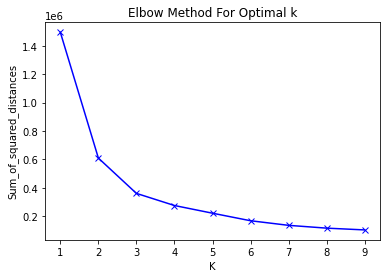

In [33]:
plt.plot(clusters, inertia, 'bx-')
plt.xlabel('K')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

K = 2 or 3 would be better

**Train the clusters on 60 dimensions (PHQ,TPHYSTND)**

In [18]:
normalize_flag = True
mean = train_data_m4k.norm_ds['mean'][64:124].values
inertia = []

In [ ]:
for n_clusters in clusters:
    print("n_clusters: "+str(n_clusters))
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,random_state=0,batch_size=n_batches)  
    for i in tqdm(range(train_data_m4k.n_batches)):
        Y = train_data_m4k[i][1]
        #inverse scale and then subtrac mean and then scale
        Y = train_data_m4k.output_transform.inverse_transform(Y)
        Y[:,:60] = Y[:,:60] - mean
        Y = train_data_m4k.output_transform.transform(Y)
        X = Y[:,:60] #PHQ-TPHYSTND
        kmeans = kmeans.partial_fit(X)
    inertia.append(kmeans.inertia_)
    save_pickle_model(MODEL_DIR+"PHQTPH_normalized_K_"+str(n_clusters)+".pkl",kmeans)

n_clusters: 1


/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



n_clusters: 2


/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



n_clusters: 3


/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



n_clusters: 4


/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



n_clusters: 5


/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



n_clusters: 6


/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



n_clusters: 7


/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



n_clusters: 8


/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



n_clusters: 9


/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


load the models and plot the inertia

In [10]:
inertia = []
for n_clusters in clusters:
    kmeans = load_pickle_model(MODEL_DIR+"PHQTPH_normalized_K_"+str(n_clusters)+".pkl")
    inertia.append(kmeans.inertia_)

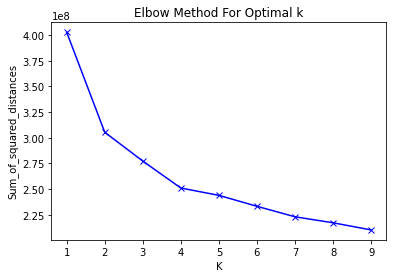

In [11]:
plt.plot(clusters, inertia, 'bx-')
plt.xlabel('K')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

k=4 would be a good choice

# Diagnositics

**Clustering of mean data**

/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


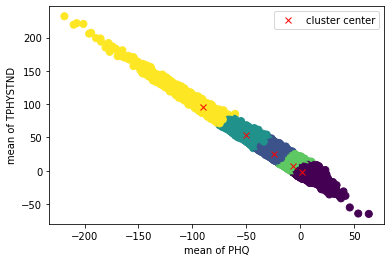

In [69]:
#plot 100000 data points i.e 
for i in tqdm(range(int(1000000/batch_size))):
    Y = train_data_m4k[i][1]
    PHQ = Y[:,PHQ_idx].mean(axis=1)
    TPHYSTND = Y[:,TPHYSTND_idx].mean(axis=1)
    X = np.vstack((PHQ,TPHYSTND)).T
    pred = kmeans.predict(X)
    plt.scatter(X[:,0],X[:,1],c=pred, s=50, cmap='viridis')
plt.plot(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],'x',c='r')
plt.xlabel("mean of PHQ")
plt.ylabel("mean of TPHYSTND")
plt.legend(['cluster center'])

**K=5**

In [14]:
## Load the k=3 model
kmeans = load_pickle_model(MODEL_DIR+"PHQ_TPH_mean_K_3.pkl")

/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


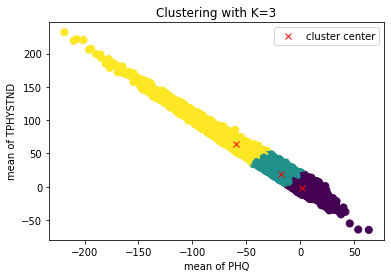

In [16]:
for i in tqdm(range(int(1000000/batch_size))):
    Y = train_data_m4k[i][1]
    PHQ = Y[:,PHQ_idx].mean(axis=1)
    TPHYSTND = Y[:,TPHYSTND_idx].mean(axis=1)
    X = np.vstack((PHQ,TPHYSTND)).T
    pred = kmeans.predict(X)
    plt.scatter(X[:,0],X[:,1],c=pred, s=50, cmap='viridis')
plt.plot(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],'x',c='r')
plt.xlabel("mean of PHQ")
plt.ylabel("mean of TPHYSTND")
plt.title("Clustering with K=3")
plt.legend(['cluster center'])

**Clustering of PHQ-TPHYSTND data**

In [23]:
#run pca to bring it to a 2 dimension space
pca = IncrementalPCA(n_components=2)
kmeans = load_pickle_model(MODEL_DIR+"PHQTPH_normalized_K_4.pkl")
mean = train_data_m4k.norm_ds['mean'][64:124].values

In [26]:
kmeans.cluster_centers_.shape

(4, 60)

/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Clustering with K=4 concatened')

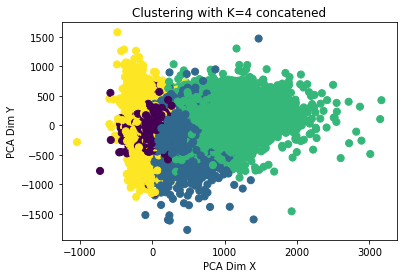

In [32]:
for i in tqdm(range(int(1000000/batch_size))):
    Y = train_data_m4k[i][1]
    #inverse scale and then subtrac mean and then scale
    Y = train_data_m4k.output_transform.inverse_transform(Y)
    Y[:,:60] = Y[:,:60] - mean
    Y = train_data_m4k.output_transform.transform(Y)
    X = Y[:,:60] #PHQ-TPHYSTND
    X_fitted = pca.fit_transform(X)
    pred = kmeans.predict(X)
    plt.scatter(X_fitted[:,0],X_fitted[:,1],c=pred, s=50, cmap='viridis')
plt.xlabel("PCA Dim X")
plt.ylabel("PCA Dim Y")
plt.title("Clustering with K=4 concatened")


### Plotting (SOLIN,PS,LHFLX,SHFLX) (K=3,4,5,6)

In [35]:
train_data_m4k =  DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1000000,
    shuffle=True,
    normalize_flag=True
)

**Plotting SOLIN**

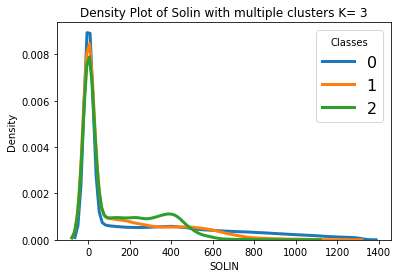

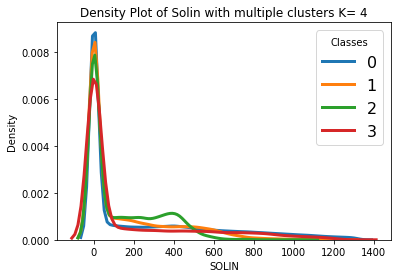

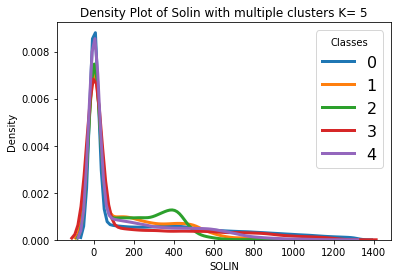

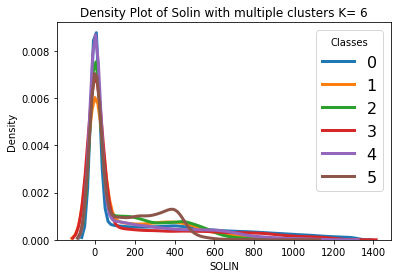

In [53]:

for K in [3,4,5,6]:
    kmeans = load_pickle_model(MODEL_DIR+"PHQTPH_normalized_K_"+str(K)+".pkl")
    Y = train_data_m4k[0][1]
    #inverse scale and then subtrac mean and then scale
    Y = train_data_m4k.output_transform.inverse_transform(Y)
    Y[:,:60] = Y[:,:60] - mean
    Y = train_data_m4k.output_transform.transform(Y)
    X = Y[:,:60] #PHQ-TPHYSTND        
    preds = kmeans.predict(X)
    for k in range(K):
        SOLIN = Y[preds==k,60]
        sns.distplot(SOLIN, hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = k)

    plt.legend(prop={'size': 16}, title = 'Classes')
    plt.title('Density Plot of Solin with multiple clusters K= '+str(K))
    plt.xlabel('SOLIN')
    plt.ylabel('Density')
    plt.show()


**Plotting PS**

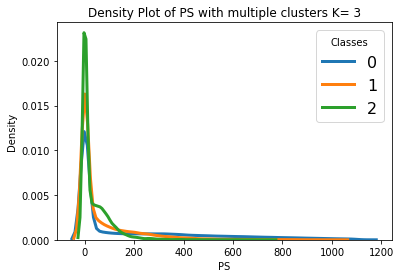

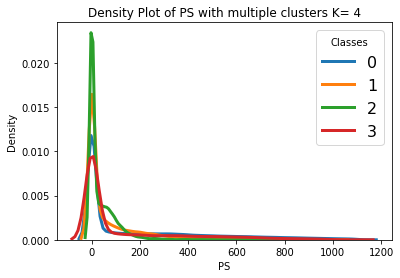

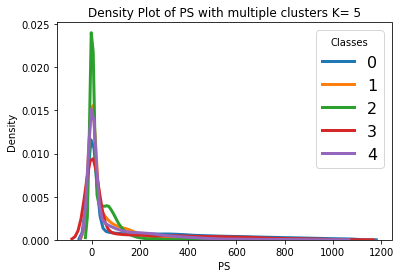

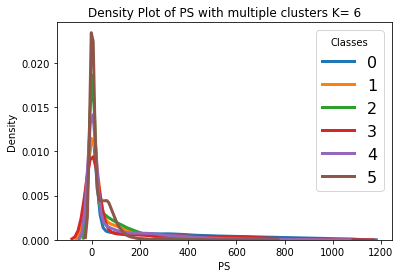

In [54]:
for K in [3,4,5,6]:
    kmeans = load_pickle_model(MODEL_DIR+"PHQTPH_normalized_K_"+str(K)+".pkl")
    Y = train_data_m4k[0][1]
    #inverse scale and then subtrac mean and then scale
    Y = train_data_m4k.output_transform.inverse_transform(Y)
    Y[:,:60] = Y[:,:60] - mean
    Y = train_data_m4k.output_transform.transform(Y)
    X = Y[:,:60] #PHQ-TPHYSTND        
    preds = kmeans.predict(X)
    for k in range(K):
        PS = Y[preds==k,61]
        sns.distplot(PS, hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = k)

    plt.legend(prop={'size': 16}, title = 'Classes')
    plt.title('Density Plot of PS with multiple clusters K= '+str(K))
    plt.xlabel('PS')
    plt.ylabel('Density')
    plt.show()

**Plotting LHFLX**

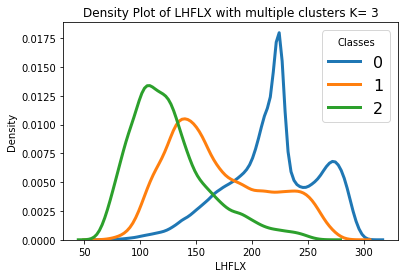

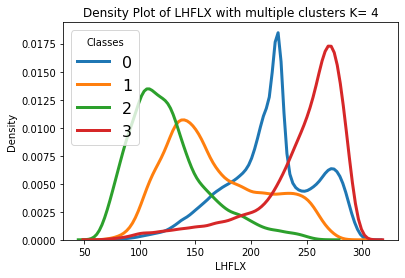

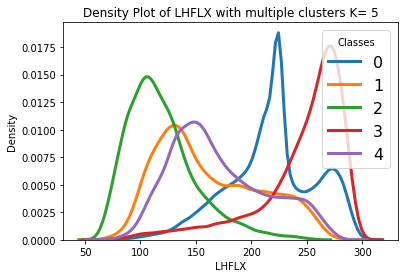

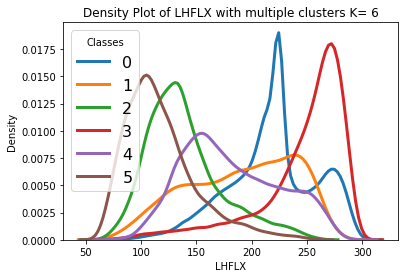

In [56]:
for K in [3,4,5,6]:
    kmeans = load_pickle_model(MODEL_DIR+"PHQTPH_normalized_K_"+str(K)+".pkl")
    Y = train_data_m4k[0][1]
    #inverse scale and then subtrac mean and then scale
    Y = train_data_m4k.output_transform.inverse_transform(Y)
    Y[:,:60] = Y[:,:60] - mean
    Y = train_data_m4k.output_transform.transform(Y)
    X = Y[:,:60] #PHQ-TPHYSTND        
    preds = kmeans.predict(X)
    for k in range(K):
        LHFLX = Y[preds==k,62]
        sns.distplot(LHFLX, hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = k)

    plt.legend(prop={'size': 16}, title = 'Classes')
    plt.title('Density Plot of LHFLX with multiple clusters K= '+str(K))
    plt.xlabel('LHFLX')
    plt.ylabel('Density')
    plt.show()

**Plotting SHFLX**

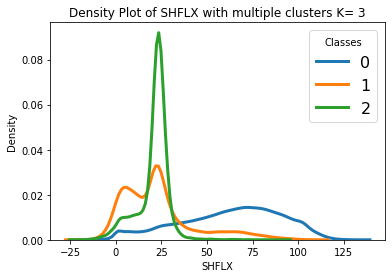

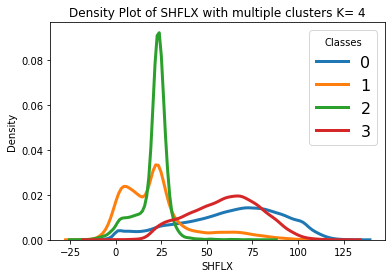

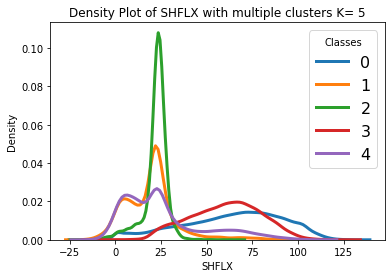

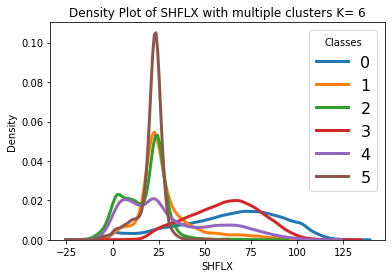

In [58]:
for K in [3,4,5,6]:
    kmeans = load_pickle_model(MODEL_DIR+"PHQTPH_normalized_K_"+str(K)+".pkl")
    Y = train_data_m4k[0][1]
    #inverse scale and then subtrac mean and then scale
    Y = train_data_m4k.output_transform.inverse_transform(Y)
    Y[:,:60] = Y[:,:60] - mean
    Y = train_data_m4k.output_transform.transform(Y)
    X = Y[:,:60] #PHQ-TPHYSTND        
    preds = kmeans.predict(X)
    for k in range(K):
        SHFLX = Y[preds==k,63]
        sns.distplot(SHFLX, hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = k)

    plt.legend(prop={'size': 16}, title = 'Classes')
    plt.title('Density Plot of SHFLX with multiple clusters K= '+str(K))
    plt.xlabel('SHFLX')
    plt.ylabel('Density')
    plt.show()

In [11]:
lev.values

array([  3.64346569,   7.59481965,  14.35663225,  24.61222   ,
        38.26829977,  54.59547974,  72.01245055,  87.82123029,
       103.31712663, 121.54724076, 142.99403876, 168.22507977,
       197.9080867 , 232.82861896, 273.91081676, 322.24190235,
       379.10090387, 445.9925741 , 524.68717471, 609.77869481,
       691.38943031, 763.40448111, 820.85836865, 859.53476653,
       887.02024892, 912.64454694, 936.19839847, 957.48547954,
       976.32540739, 992.55609512])

### Plotting The Mean Profile

In [43]:
train_data_m4k =  DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=100000,
    shuffle=True,
    normalize_flag=True
)
mean = train_data_m4k.norm_ds['mean'][64:124].values

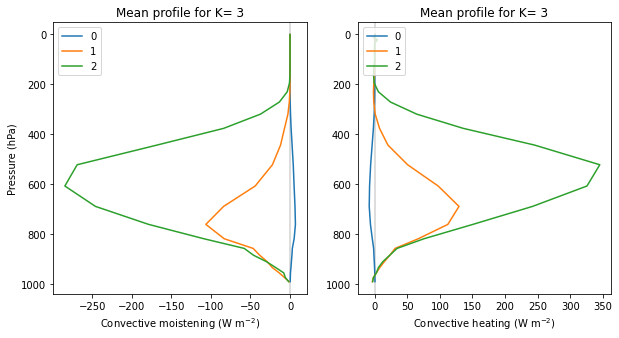

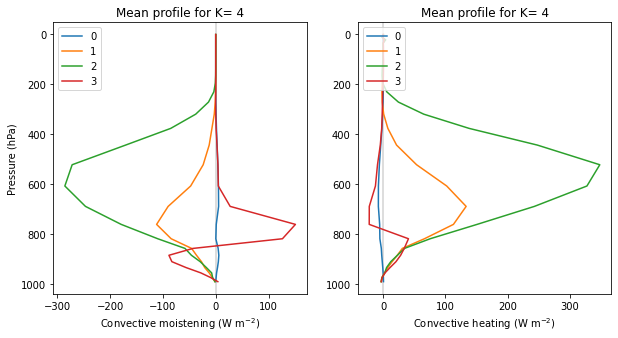

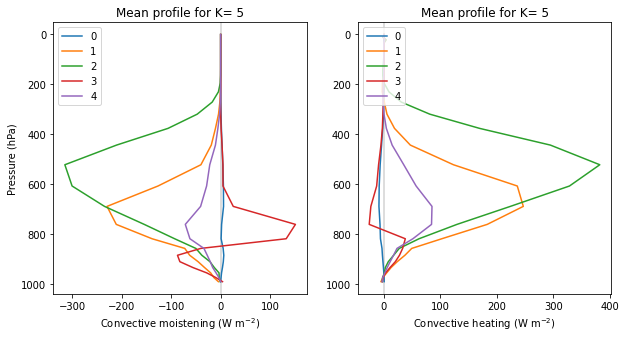

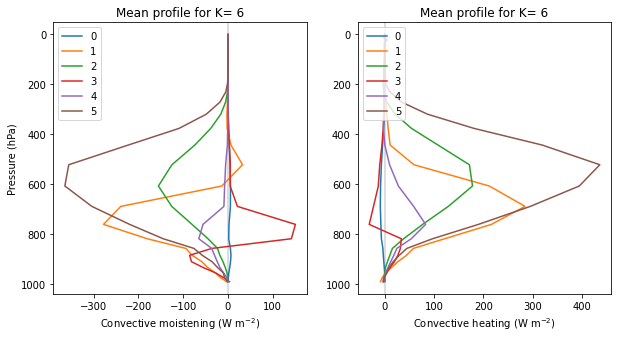

In [44]:


for K in [3,4,5,6]:
    kmeans = load_pickle_model(MODEL_DIR+"PHQTPH_normalized_K_"+str(K)+".pkl")
    Y = train_data_m4k[0][1]
    #inverse scale and then subtrac mean and then scale
    Y = train_data_m4k.output_transform.inverse_transform(Y)
    Y[:,:60] = Y[:,:60] - mean
    Y = train_data_m4k.output_transform.transform(Y)
    
    PHQ = Y[:,PHQ_idx]
    TPHYSTND = Y[:,TPHYSTND_idx]
    
    X = Y[:,:60] #PHQ-TPHYSTND        
    preds = kmeans.predict(X)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.axvline(x=0,c='lightgray')
    
    for k in range(K):
        PHQ_k = PHQ[preds==k].mean(axis=0)
        plt.plot(PHQ_k,lev,label=k)
    plt.legend(loc="upper left")
    plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
    plt.ylabel('Pressure (hPa)')
    plt.gca().invert_yaxis()
    plt.title("Mean profile for K= "+str(K))
    
    plt.subplot(1,2,2)
    plt.axvline(x=0,c='lightgray')
    
    for k in range(K):
        TPHYSTND_k = TPHYSTND[preds==k].mean(axis=0)
        plt.plot(TPHYSTND_k,lev,label=k)
        
    plt.legend(loc="upper left")
    plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
    plt.gca().invert_yaxis()
    plt.title("Mean profile for K= "+str(K))
    
    plt.show()
